# Natural Language Processing with Disaster Tweets: Assessing predictive performance of the baseline LSTM, GRU and their hybrid counterpart

**Jay Manvirk (Ivan Loginov)**<br/>
University of Colorado, Boulder<br/>
jay.manvirk@gmail.com

# Table of Contents

1. [Abstract](#chapter_1)
2. [Introduction](#chapter_2)
3. [Libraries and raw data](#chapter_3)
    - 3.1 [Libraries](#chapter_3_1)
    - 3.2 [Raw data](#chapter_3_2)
4. [Exploratory data analysis](#chapter_4)
    - 4.1 [Short datasets summary](#chapter_4_1)
    - 4.2 [Number of records per class](#chapter_4_2)
    - 4.3 [Word frequencies per class](#chapter_4_3)
5. [Data preprocessing](#chapter_5)
    - 5.1 [Sampling](#chapter_5_1)
    - 5.2 [Text cleaning](#chapter_5_2)
    - 5.3 [Text tokenization](#chapter_5_3)
    - 5.4 [Word2Vec](#chapter_5_4)
    - 5.5 [Train-test split](#chapter_5_5)
6. [Model architectures](#chapter_6)
    - 6.1 [LSTM](#chapter_6_1)
    - 6.2 [GRU](#chapter_6_2)
    - 6.3 [Hybrid](#chapter_6_3)
7. [Model results](#chapter_7)
8. [Submission results](#chapter_8)
9. [Conclusion](#chapter_9)
10. [References](#chapter_10)

# 1. Abstract <a class="anchor" id="chapter_1"></a>

TODO

# 2. Introduction <a class="anchor" id="chapter_2"></a>

TODO

# 3. Libraries and data <a class="anchor" id="chapter_3"></a>

## 3.1 Libraries <a class="anchor" id="chapter_3_1"></a>

In [143]:
# basics
import os
import time
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import re
import spacy
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from concurrent.futures import ProcessPoolExecutor
from sklearn.model_selection import train_test_split

# Model architectures
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Utilities
import keras.backend as K
from tensorflow.keras.models import load_model

## 3.2 Raw Data <a class="anchor" id="chapter_3_2"></a>

In [6]:
# Print list of files in folder
files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
files

['/kaggle/input/nlp-getting-started/sample_submission.csv',
 '/kaggle/input/nlp-getting-started/train.csv',
 '/kaggle/input/nlp-getting-started/test.csv']

In [7]:
# Set datasets
train_data = pd.read_csv(files[1])
test_data = pd.read_csv(files[2])
submit_data = pd.read_csv(files[0])

In [8]:
# Cleaning
del files

# 4. Exploratory data analysis <a class="anchor" id="chapter_4"></a>

## 4.1 Short datasets summary <a class="anchor" id="chapter_4_1"></a>

Our dataset has some missing values in the keyword and location columns. If we remove these entries, we'll lose about 33% of the data. Since we're concentrating on Twitter texts, we can keep the null values and use all the available information.

In [9]:
def print_short_summary(name, data):
    """
    Print data head, shape and info.
    
    Args:
        name (str): name of dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2 Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()

In [10]:
print_short_summary('Train data', train_data)

Train data

1. Data head:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

2 Data shape: (7613, 5)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)

In [11]:
print_short_summary('Test data', test_data)

Test data

1. Data head:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

2 Data shape: (3263, 4)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [12]:
print_short_summary('Sample submission data', submit_data)

Sample submission data

1. Data head:
   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0

2 Data shape: (3263, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


In [13]:
# Cleaning
del print_short_summary

## 4.2 Number of records per class <a class="anchor" id="chapter_4_2"></a>

The dataset has fewer disastrous tweets (about 30% less) compared to non-disastrous ones, creating an imbalance. To address this, we will adjust the number of non- and disastrous tweets to balance the classes.

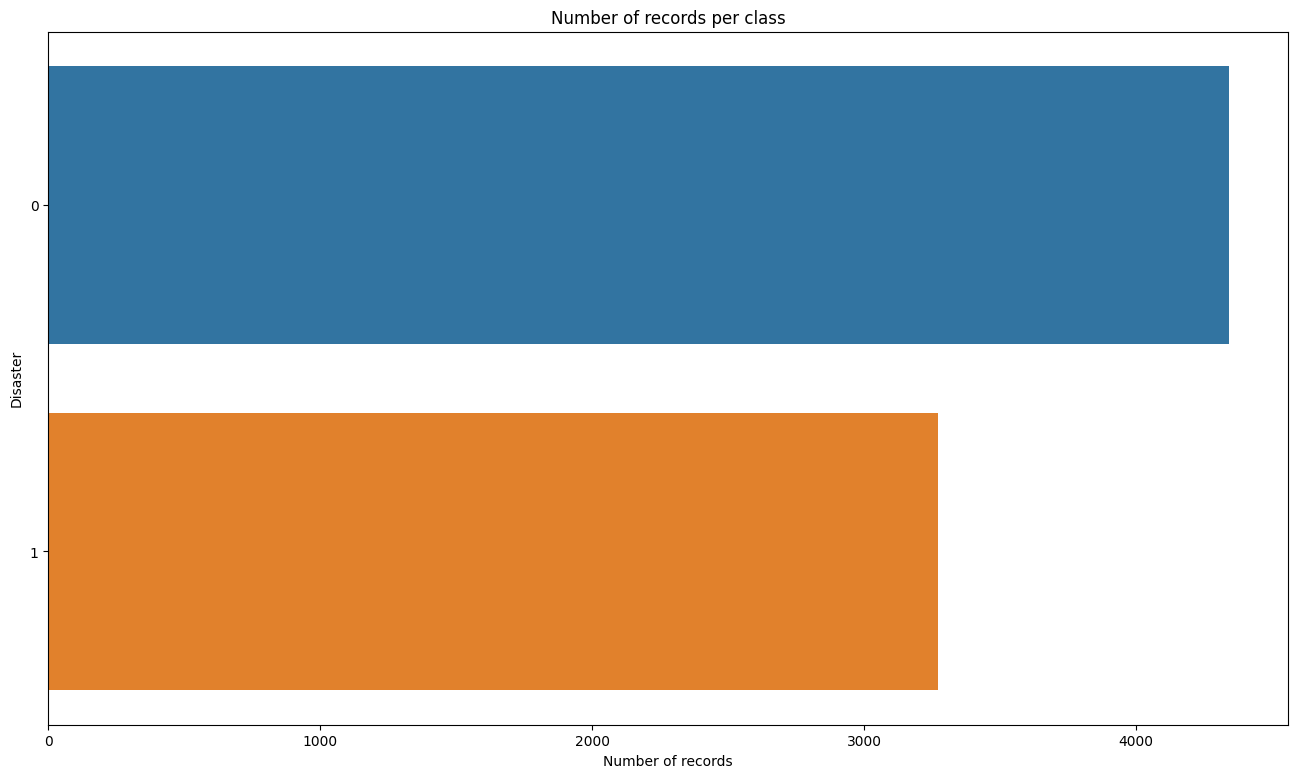

In [14]:
# Plot horizontal barplot of the number of records per class
plt.figure(figsize=(16, 9))
tmp = train_data['target'].value_counts()
sns.barplot(y=tmp.index.values, x=tmp.values, orient='h')
plt.xlabel('Number of records')
plt.ylabel('Disaster')
plt.title('Number of records per class')
plt.show()

In [15]:
# Cleaning
del tmp

## 4.3 Word frequencies per class <a class="anchor" id="chapter_4_3"></a>

There's a significant overlap in words used across both classes, which doesn't provide specific class-related information. To minimize this noise, we'll clean the data in the following sections.

In [16]:
def plot_word_dist_class(labels, top_n_words = 10):
    """
    Plot charts with word frequencies per class.
    
    Args:
        labels: list of classes
        top_n_words (opt): how many top words to plot in one chart
    """
    n = len(labels)
    
    # Get default seaborn's palette to match colours with the previous chart
    default_palette = sns.color_palette("deep")
    
    # Initialize subplots with 1 row and n columns
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(16, 9))
    
    # Plot word count per author in the respective rows
    for i in range(n):
        col = i % n
        indexes = train_data['target'] == labels[i]
        w = train_data['text'][indexes].str.split(expand=True).unstack().value_counts()
        l = w[:top_n_words]/np.sum(w)*100
        axes[col].bar(l.index, l.values, color=default_palette[i])
        axes[col].set_title(labels[i])
        axes[col].set_xlabel('Words')
        axes[col].set_ylabel('Percentage of total word count (%)')

    plt.tight_layout()
    plt.show()

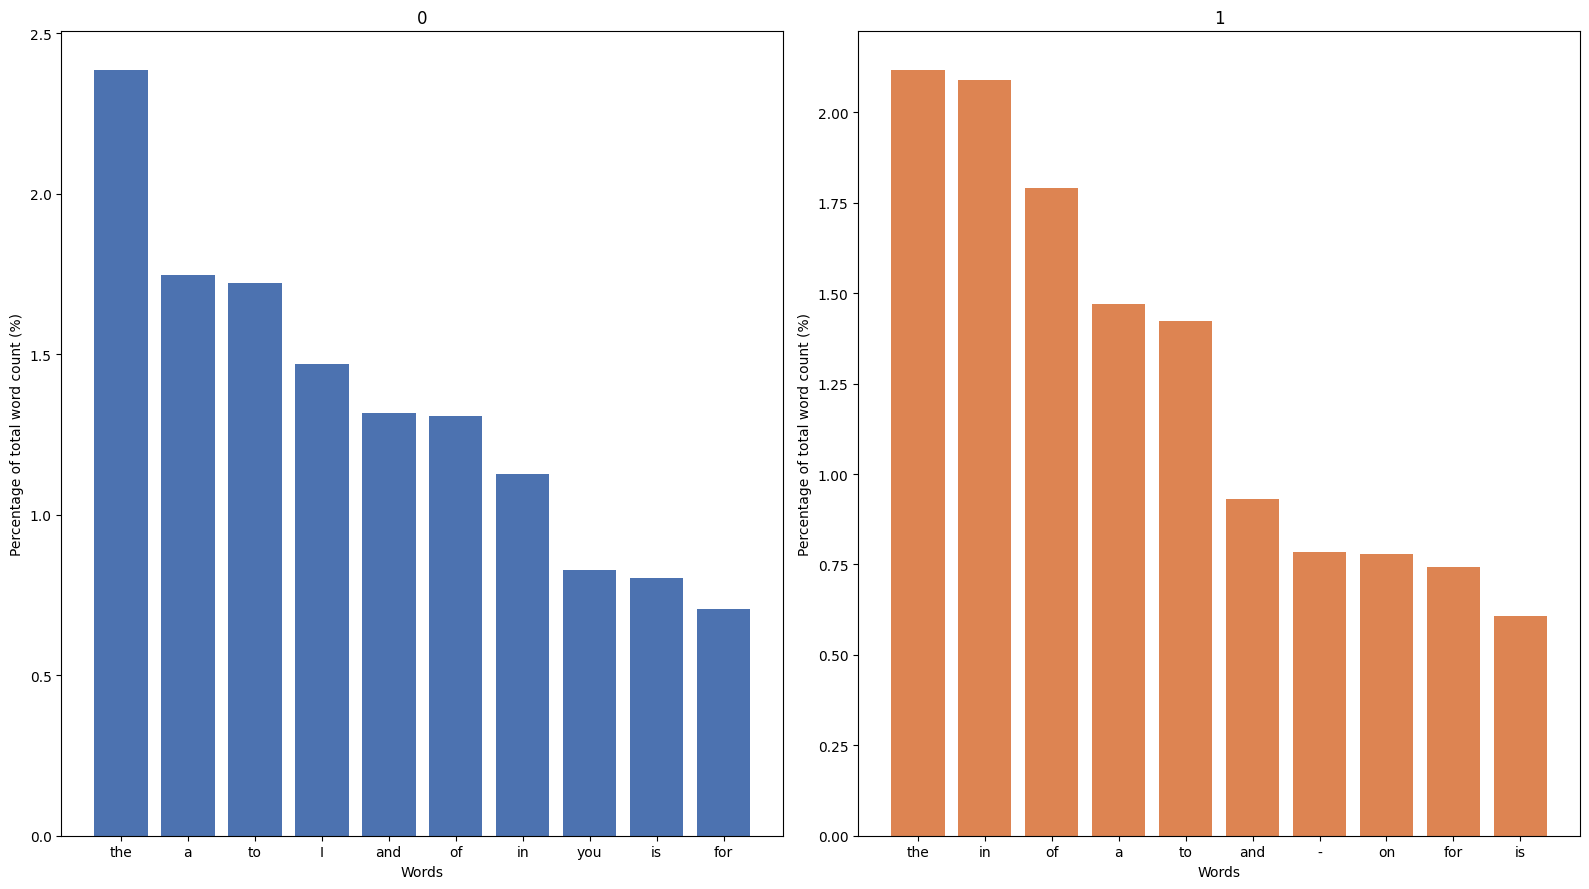

In [17]:
# Plot word frequencies by class
plot_word_dist_class([0,1])

In [18]:
# Cleaning
del plot_word_dist_class

# 5. Data preprocessing <a class="anchor" id="chapter_5"></a>

## 5.1 Text cleaning <a class="anchor" id="chapter_5_2"></a>

In this step, we'll get rid of single letters and the most common stopwords identified during our EDA. By doing so, we improve the model's accuracy in determining the class of each tweet.

In [19]:
# Load english lemmas
spacy_process = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Compile regex pattern
pattern = re.compile(r'\b([a-zA-Z])\b')

# Set english stopwords such
stop_words = set(stopwords.words('english'))

In [20]:
def get_processed_text(text):
    """
    Return lemmatized text without single letters and frequent stopwords.
    Everything is in the lower case register.
    
    Args:
        text (str): text of an article
    Returns:
        string: text of clean lemmas
    """
    # Convert to lowercase single letters
    text = pattern.sub('', text.lower())
    
    # Get lemma tokens
    lemmas = spacy_process(text)
    lemmas = [token.lemma_ for token in lemmas if token.text not in stop_words]
    
    return ' '.join(lemmas)

def get_clean_text(texts):
    """
    Return list of cleaned texts.
    Execution in parallel.
    
    Args:
        texts: numpy array of string elements
    Returns:
        list: list of cleaned lemmatized tokens
    """
    # Set up parallel tasks processing 
    with ProcessPoolExecutor() as executor:
        clean_texts = list(executor.map(get_processed_text, texts))
        
    return clean_texts

In [21]:
# Get cleaned train and test texts
train_text_clean = get_clean_text(train_data['text'].values)
test_text_clean = get_clean_text(test_data['text'].values)

In [22]:
# Set clean train and test dataframes with classes
train_data_clean = pd.DataFrame({
    'text': train_text_clean
    , 'target': train_data['target'].values
})
test_data_clean = pd.DataFrame({
    'text': test_text_clean
})

In [23]:
# Cleaning
del spacy_process, pattern, stop_words
del get_clean_text, get_processed_text

## 5.2 Sampling <a class="anchor" id="chapter_5_2"></a>

This section focuses on balancing the class distribution in the training dataset by increasing and decreasing the number of disastrous tweet samples through upsampling and downsampling respectively. These adjustments will help us analyze if additional sampling enhances the models' pattern learning capabilities.

In [24]:
# Get maximum number of records (non-disastrous)
max_count = sum(train_data_clean['target'] == 0)

# Get minimum number of records (disastrous)
min_count = sum(train_data_clean['target'] == 1)

# Upsample siastrous tweets to the max number of non-disastrous
data_upsampled = []
data_downsampled = []
for i in range(2):
    class_data = train_data_clean[train_data_clean['target'] == i]
    class_data_up = class_data.sample(max_count
                                     , replace = True
                                     , random_state = 0)
    class_data_down = class_data.sample(min_count
                                     , replace = True
                                     , random_state = 0)
    data_upsampled.append(class_data_up)
    data_downsampled.append(class_data_down)

train_data_clean_upsamp = pd.concat(data_upsampled)
train_data_clean_downsamp = pd.concat(data_downsampled)

In [25]:
# Print class distribution of the upsampled data
print('Upsampled training data:')
train_data_clean_upsamp['target'].value_counts()

Upsampled training data:


target
0    4342
1    4342
Name: count, dtype: int64

In [26]:
# Print class distribution of the downsampled data
print('Downsampled training data:')
train_data_clean_downsamp['target'].value_counts()

Downsampled training data:


target
0    3271
1    3271
Name: count, dtype: int64

In [27]:
# Cleaning
del max_count, min_count, class_data, class_data_down, class_data_up
del data_upsampled, data_downsampled

## 5.3 Text tokenization <a class="anchor" id="chapter_5_3"></a>

In this section we create a list of lists, where each inner list represents a sentence. The numbers in these lists are word indices from the original sentences. These numerical sequences are later going to be used for training in Word2Vec.

In [28]:
# Create and fit Tokenizer object
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_clean['text'].values)

# Convert text to the list of word indexes in corpus
data_list = [train_data_clean
             , train_data_clean_upsamp
             , train_data_clean_downsamp
            ]
sequences_list = []
for data in data_list:
    sequences_list.append(tokenizer.texts_to_sequences(data['text'].values))

# Get vocabulary size for embedding matrix
VOCAB_SIZE = len(tokenizer.word_index) + 1

## 5.4 Word2Vec <a class="anchor" id="chapter_5_4"></a>

Word2Vec transforms tokens into high-dimensional vectors, making them suitable for deep learning models. It converts them into vector representations. By predicting, in our case, word indices based on neighboring indices, Word2Vec enhances the neural network's understanding of token relationships, improving overall learning.
* sequences: list of tokens or their representatives in a sentence
* vector_size: dimensionality of the word vectors; the higher value the better chances to capture specific relationships between tokens
* window = 3: maximum distance between the current and predicted token within a sentence; higher value allows to capture relationships of a bigger group of tokens
* min_count = 1: threshold of the token occurence below which Word2Vec will ignore it; setting it to 1 we include all words in the training
* workers: number of CPU cores to train model in parallel

In [29]:
# Get maximum available number of CPU cores for Word2Vec training
workers = os.cpu_count()

# Set dimensionality
VECTOR_SIZE = 100

# Create Word2Vec model
w2v_model = Word2Vec(sentences = sequences_list[0]
         , vector_size = VECTOR_SIZE
         , window = 3
         , min_count = 1
         , workers = workers)

# Create embedding matrix using Word2Vec embeddings
EMBED_MATRIX = np.zeros((VOCAB_SIZE, VECTOR_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        EMBED_MATRIX[i] = w2v_model.wv[word]

In [30]:
del workers

## 5.5 Train-test split <a class="anchor" id="chapter_5_5"></a>

In [99]:
# Get maximum sequence length
MAX_SEQ_LEN = max(map(len, sequences_list[0]))

# Pad sequences to the same length for neural network
X = []
for sequences in sequences_list:
    X.append(pad_sequences(sequences, maxlen = MAX_SEQ_LEN, padding='post'))

# Set target classes
y = []
for data in data_list:
    y.append(data['target'].values)

# Split data into training and testing sets
n = len(data_list)
X_train = [None]*n
X_test = [None]*n
y_train = [None]*n
y_test = [None]*n
for i in range(n):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i])

# 6. Model architectures <a class="anchor" id="chapter_6"></a>

In [100]:
# Global configuration
NUM_EPOCHS = 10
BATCH_SIZE = 64

# These variables were declared in the previous sections
# MAX_SEQ_LEN
# VECTOR_SIZE
# VOCAB_SIZE
# EMBED_MATRIX

In [112]:
def get_model(custom_layers):
    """
    Return baseline RNN model with custom layer and Word2Vec embeddings.
    
    Args:
        keras layer: layer of the RNN model
    Returns:
        keras model
    """    
    model = Sequential([
        layers.Embedding(VOCAB_SIZE
                        , VECTOR_SIZE
                        , weights = [EMBED_MATRIX]
                        , input_length = MAX_SEQ_LEN
                        , trainable=True)
    ])
    for layer in custom_layers:
        model.add(layer)
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

## 6.1 LSTM <a class="anchor" id="chapter_6_1"></a>

TODO

In [113]:
def get_model_lstm():
    """
    Reuturn RNN model with baseline LSTM layer and Word2Vec embeddings.
    
    Returns:
        keras model
    """
    custom_layers = [layers.LSTM(128)]
    
    return get_model(custom_layers)

## 6.2 GRU <a class="anchor" id="chapter_6_2"></a>

TODO

In [131]:
def get_model_gru():
    """
    Build RNN model with baseline GRU layer and Word2Vec embeddings.
    
    Returns:
        keras model
    """    
    custom_layers = [layers.GRU(128)]
    
    return get_model(custom_layers)

# 7. Model results <a class="anchor" id="chapter_7"></a>

TODO

In [126]:
def get_compiled_model(func):
    """
    Return model to be trained with a multi-GPU strategy.
    Allows data parallelism by copying all of the model's variables
    to each processor.
    
    Args:
        func: function to get model architecture
    Returns:
        tensorslow model: compiled model
    """
    # Check if GPU is available
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # Create a MirroredStrategy.
        strategy = tf.distribute.MirroredStrategy()

        print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
        print('No GPU available, falling back to CPU.')

    with strategy.scope():
        compiled_model = func()
        compiled_model.compile(optimizer = 'adam'
                              , loss = 'binary_crossentropy'
                              , metrics = ['accuracy'])

    return compiled_model


def get_model_results(model_name, model, X_train, y_train, X_test, y_test):
    """
    Return tuple of runtime, train and test scores.
    Compile, fit and save model along the way.
    
    Args:
        model_name: the name of model to save
        model: model to fit
        X_train: training data
        y_train: training labels
        X_test: testing data
        y_test: testing labels
    Returns:
        (runtime, (train_scores, test_scores) )
    """
    model = get_compiled_model(model)
    
    st = time.time()
    model.fit(X_train
              , y_train
              , epochs = NUM_EPOCHS
              , batch_size = BATCH_SIZE
              , validation_data = (X_test, y_test)
             )
    runtime = time.time() - st
    
    model.save('{}.h5'.format(model_name))
    
    train_scores = model.history.history['accuracy']
    test_scores = model.history.history['val_accuracy']
    
    tf.keras.backend.clear_session()
    
    return (runtime, (train_scores, test_scores))

def plot_model_scores(model_name_list, scores_list):
    """
    Plot train and test accuracy scores of a model by epoch
    """
    n = len(scores_list)
    # Initialize subplots with n rows and 1 column
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(16, 27))
    
    epochs = range(1, NUM_EPOCHS + 1)
    # Plot train and test scores
    for i in range(n):
        train_scores, test_scores = scores_list[i]
        model_name = model_name_list[i]
        axes[i].plot(epochs, train_scores, label='Train score')
        axes[i].plot(epochs, test_scores, label='Test score')
        axes[i].set_title('Train and test accuracy scores of the baseline {}'.format(model_name))
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Accuracy Score')
        axes[i].legend()
        axes[i].grid(True)
        
    plt.tight_layout()
    plt.show()

## 7.1 LSTM <a class="anchor" id="chapter_7_1"></a>

The charts show that the highest test accuracy, reaching 88%, was achieved with the upsampled dataset. This is likely because the LSTM had more data to learn from, allowing it to recognize patterns more effectively.

Additionally, it's crucial to note that LSTM models tend to memorize training data, as evident from the charts. Each chart displays clear signs of overfitting, with training accuracy nearing 100%, while test accuracy doesn't exceed 88%.

In [ ]:
# Get train and test scores of every epoch
n = len(X_train)
runtime_lstm = [0]*n
scores_lstm = [0]*n
for i in range(n):
    runtime_lstm[i], scores_lstm[i] = get_model_results(
        'model_lstm_{}'.format(i)
        , get_model_lstm
        , X_train[i]
        , y_train[i]
        , X_test[i]
        , y_test[i]
    )

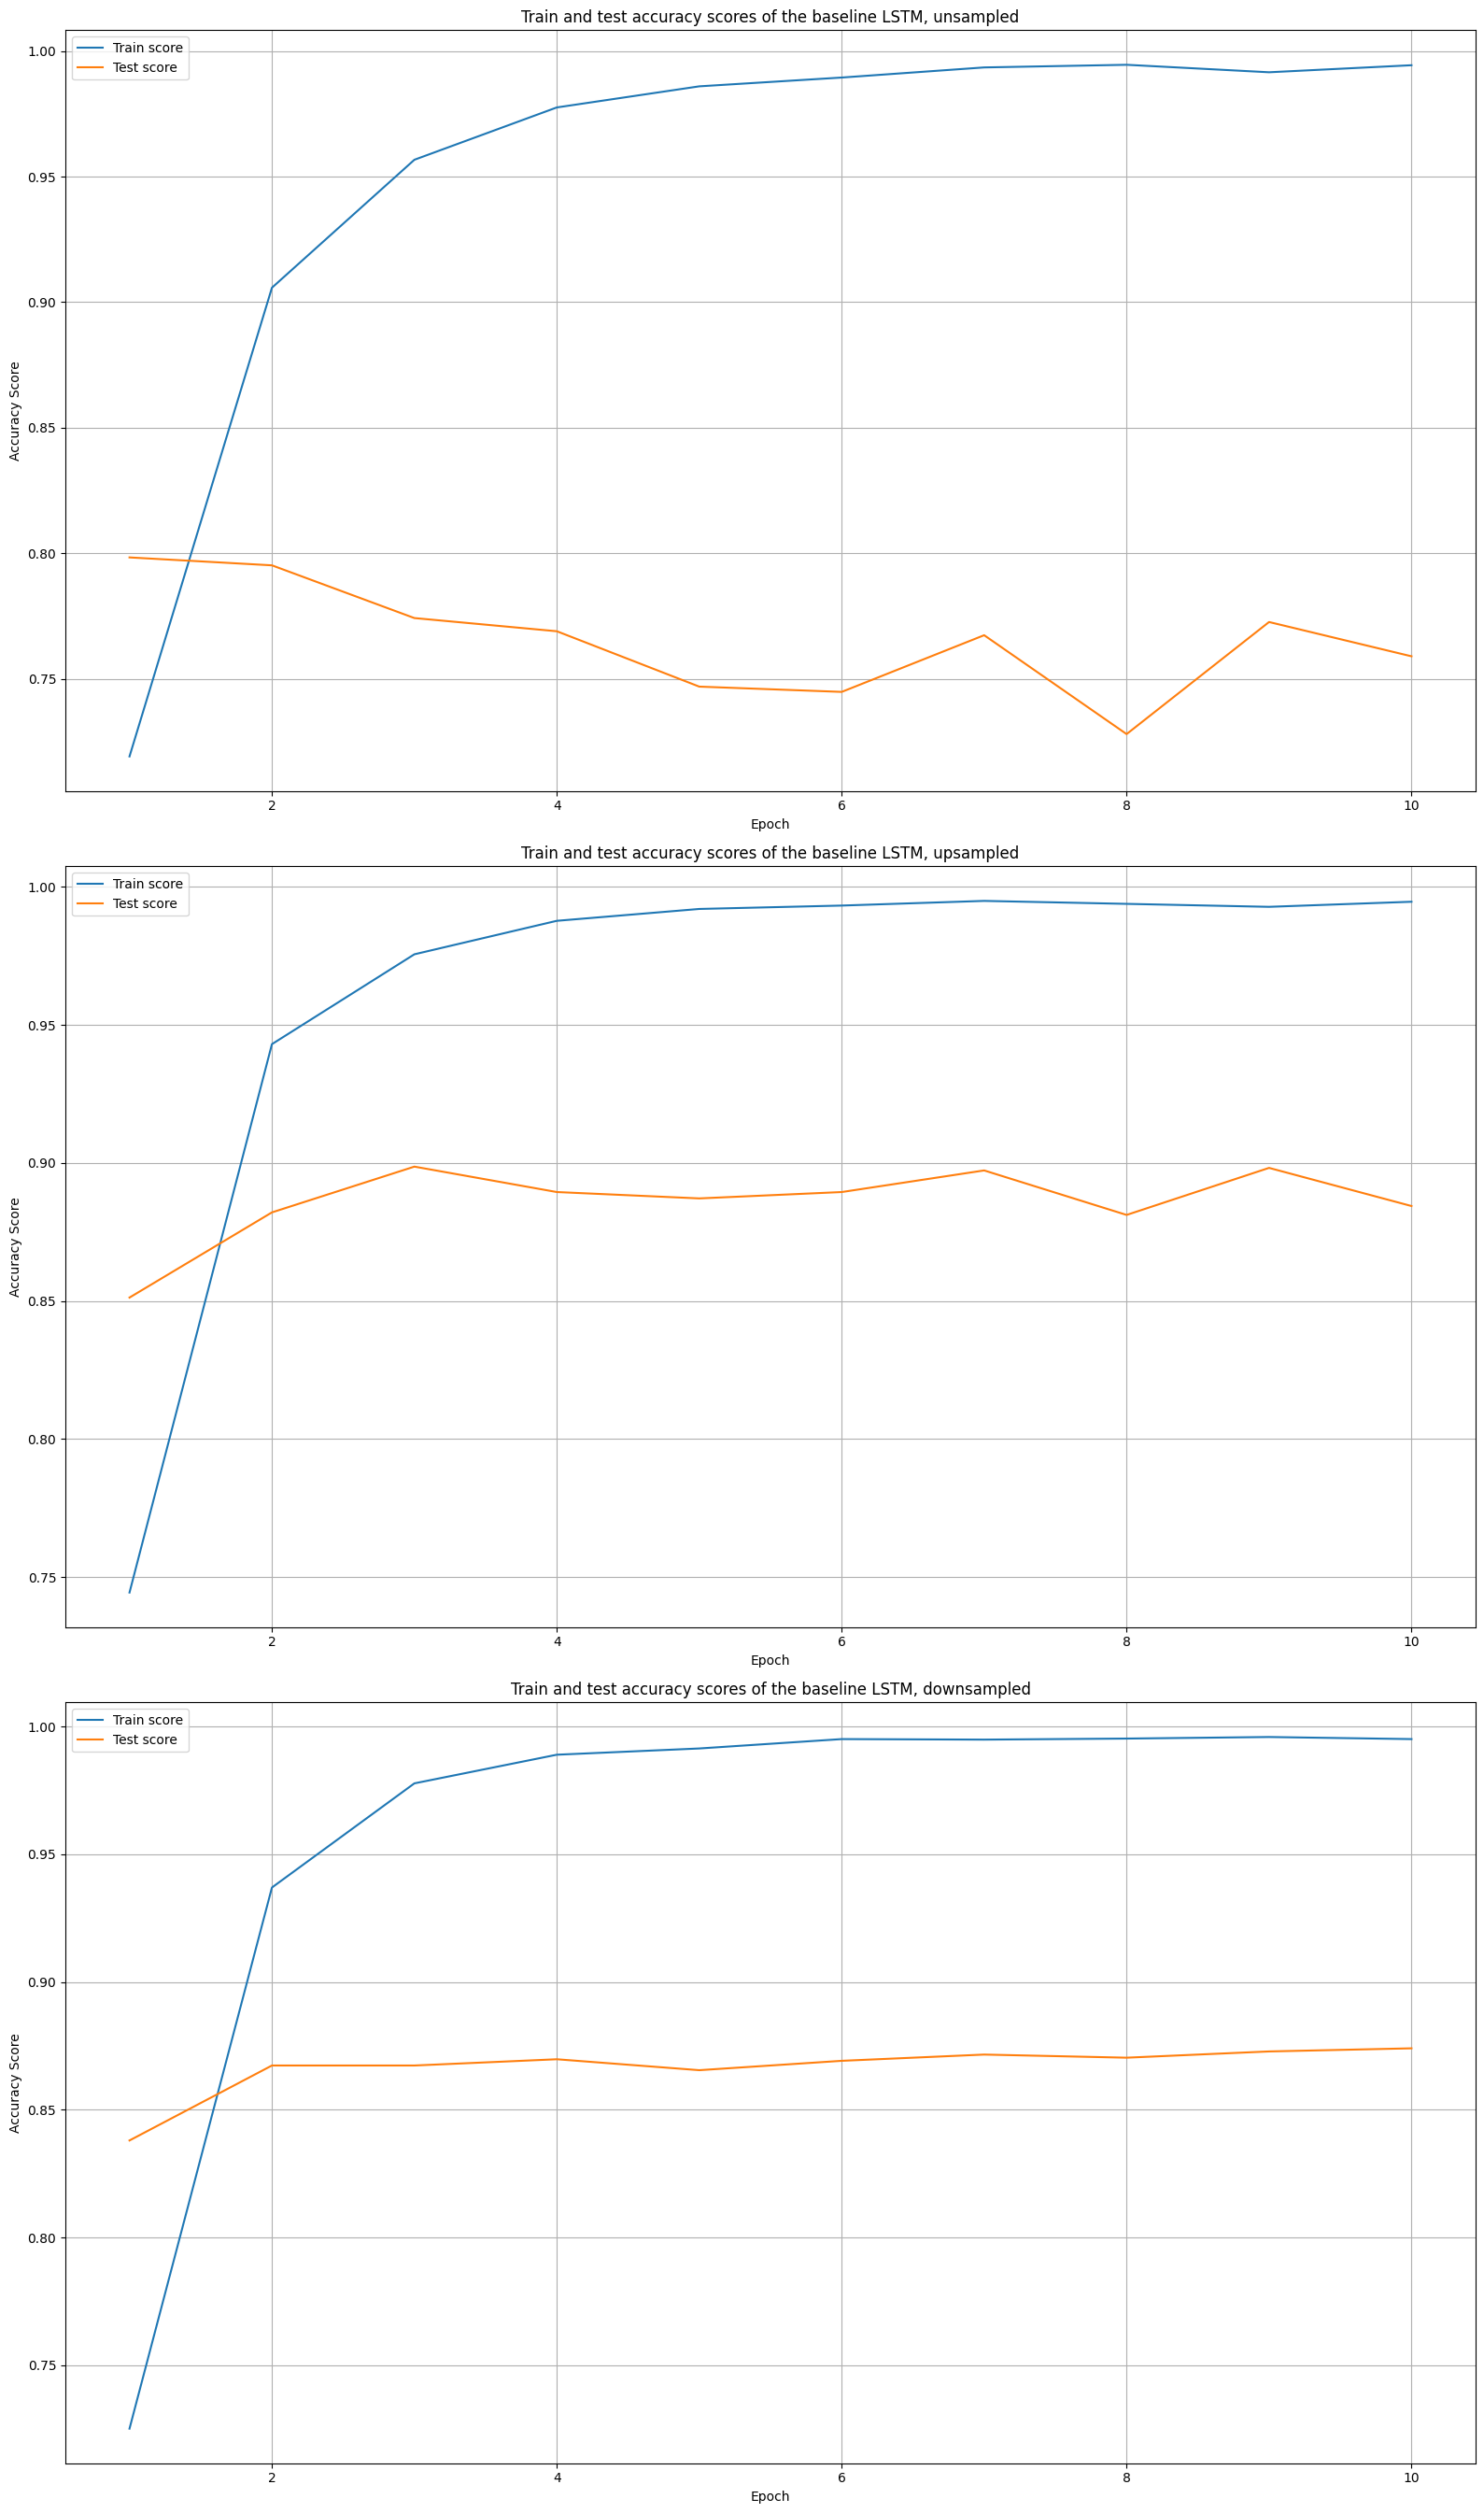

In [127]:
model_name_list = ['LSTM, unsampled', 'LSTM, upsampled', 'LSTM, downsampled']
plot_model_scores(model_name_list, scores_lstm)

## 7.2 GRU <a class="anchor" id="chapter_7_2"></a>

The GRU baseline layer exhibits a similar pattern to LSTM, showing overfitting in every training session. It reached a peak accuracy of 90%, slightly higher than LSTM.

In [ ]:
# Get train and test scores of every epoch
n = len(X_train)
runtime_gru = [0]*n
scores_gru = [0]*n
for i in range(n):
    runtime_gru[i], scores_gru[i] = get_model_results(
        'model_gru_{}'.format(i)
        , get_model_gru
        , X_train[i]
        , y_train[i]
        , X_test[i]
        , y_test[i]
    )

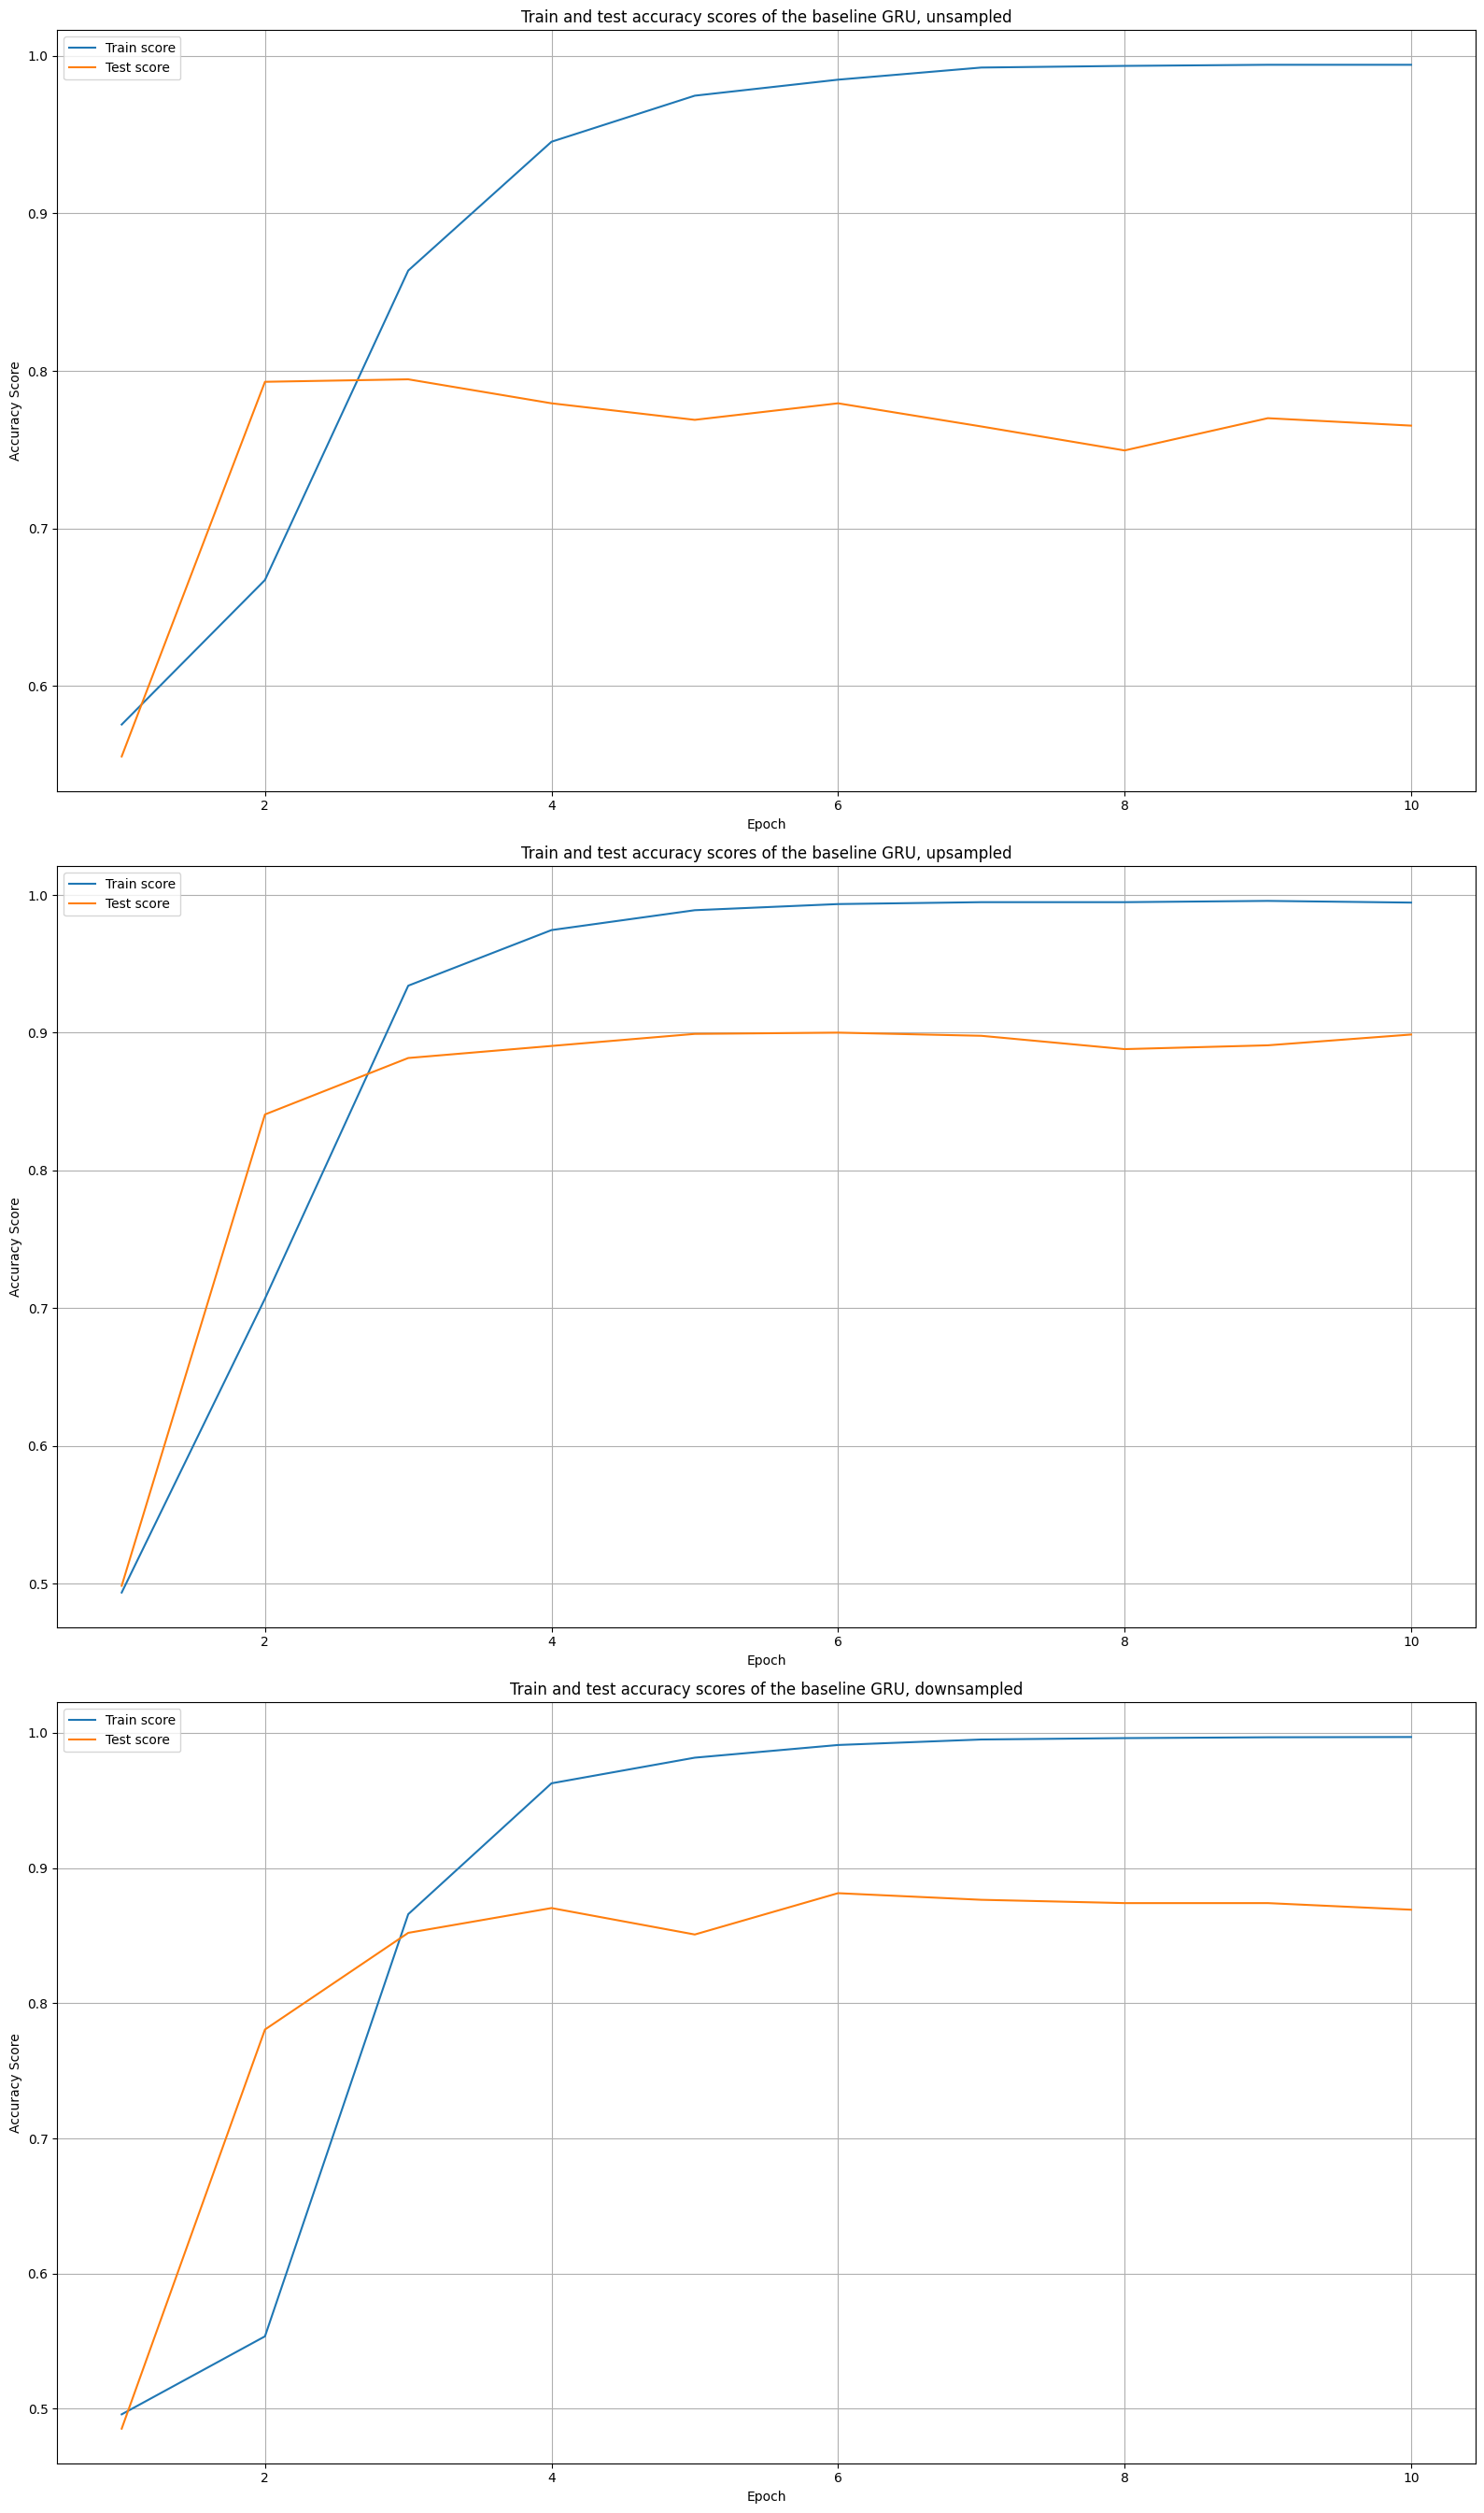

In [133]:
model_name_list = ['GRU, unsampled', 'GRU, upsampled', 'GRU, downsampled']
plot_model_scores(model_name_list, scores_gru)

## 7.3 Table results comparison <a class="anchor" id="chapter_7_3"></a>

In [141]:
# Print table results
types = ['LSTM', 'GRU']
sampling = ['original', 'upsampled', 'downsampled']
scores = [scores_lstm, scores_gru]
runtimes = [runtime_lstm, runtime_gru]
table = []
for i in range(2):
    for j in range(n):
        tmp = {
            'type': types[i]
            , 'sampling': sampling[j]
            , 'runtime (sec)': runtimes[i][j]
            , 'train_score (accuracy)': scores[i][j][0][-1]
            , 'test_score (accuracy)': scores[i][j][1][-1]
        }
        table.append(tmp)


pd.DataFrame(table).sort_values(by = ['test_score (accuracy)'
                                      ,'runtime (sec)']
                                , ascending = [False
                                               , True]).reset_index(drop = True)

,type,sampling,runtime (sec),train_score (accuracy),test_score (accuracy)
0,GRU,upsampled,43.904575,0.994473,0.898664
1,LSTM,upsampled,42.687469,0.994626,0.884385
2,LSTM,downsampled,42.999455,0.995108,0.874083
3,GRU,downsampled,31.031521,0.996943,0.869193
4,GRU,original,42.680145,0.994395,0.765231
5,LSTM,original,33.092243,0.994395,0.758929


# 8. Submission results <a class="anchor" id="chapter_8"></a>

### Public score: ???

In [144]:
# Load top model
model = load_model('model_gru_1.h5')

In [147]:
# Tokenize and convert text to sequences with the same Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_data_clean['text'].values)
test_seq = tokenizer.texts_to_sequences(test_data_clean['text'].values)

# Create padded sequences for the model input
pad_seq = pad_sequences(test_seq, maxlen = MAX_SEQ_LEN)

In [148]:
# Get predictions
predictions = model.predict(pad_seq)

102/102 [==============================] - 0s 2ms/step


In [157]:
# Set target column to predictions
submit_data['target'] = np.ravel(np.round(predictions).astype(int))

In [159]:
# Make submission
submit_data.to_csv('submission.csv', index=False)

In [ ]:
# Cleaning
del submit_data

# 9. Conclusion <a class="anchor" id="chapter_9"></a>

TODO

# 10. References <a class="anchor" id="chapter_10"></a>

* Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle.<br/>
https://kaggle.com/competitions/nlp-getting-started
* Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean. (2013). Efficient Estimation of Word Representations in Vector Space.<br/>
https://arxiv.org/abs/1301.3781
* LSTM ???
* GRU ???
* Histopathologic Cancer Detection: Exploring architectural variations and hyperparameter impact on CNN<br/>
https://www.kaggle.com/code/jaymanvirk/model-designs-impact-on-cnn
* Spooky Author Identification: Fine-tuning Logistic Regression, Random Forest, Multinomial Naive Bayes, SVM and XGBoost<br/>
https://www.kaggle.com/code/jaymanvirk/fine-tuning-logreg-rf-nb-svm-and-xgboost
* Launching parallel tasks<br/>
https://docs.python.org/3/library/concurrent.futures.html
* Distributed training with Tensorflow<br/>
https://www.tensorflow.org/guide/distributed_training
* Tensorflow GPU<br/>
https://www.tensorflow.org/guide/gpu